# **GRIP The Sparks Foundation**

### **Name:** Ankit Sharma

### **Internship:** Computer Vision & Internet of Things

### **TASK 4:** Detection of face mask

# **TRAINING NOTEBOOK**

## Importing libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, AveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Uploading dataset

In [ ]:
!pip install rarfile
import rarfile

rar_ref = rarfile.RarFile("/content/dataset.rar")
rar_ref.extractall("/tmp/FACE_DATA")
rar_ref.close()

In [ ]:
!ls "/tmp/FACE_DATA/"

'with mask'  'without mask'


In [ ]:
with_mask_dir = "/tmp/FACE_DATA/with mask"
without_mask_dir = "/tmp/FACE_DATA/without mask"

print(len(os.listdir(with_mask_dir)))
print(len(os.listdir(without_mask_dir)))

690
686


## Preprocessing dataset

In [ ]:
DATASET = "/tmp/FACE_DATA"
CATEGORIES = ["with mask","without mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# One-Hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

## Data Splitting and Augmentation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,
                                                   stratify=labels, random_state = 42)

augment = ImageDataGenerator(rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

## Implementing transfer learning using MobileNetV2

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D((7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)

# freezing baseModel layers for not training
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
opt = Adam(lr=LR,decay=LR/EPOCHS)

model.compile(loss="binary_crossentropy",optimizer=opt,
             metrics=['accuracy'])

history = model.fit(augment.flow(X_train,y_train,batch_size=BATCH_SIZE),
                   steps_per_epoch=len(X_train)//BATCH_SIZE,
                   validation_data=(X_test,y_test),
                   validation_steps=len(X_test)//BATCH_SIZE,
                   epochs=EPOCHS,callbacks=[callback])

Epoch 1/20
34/34 [==============================] - 12s 357ms/step - loss: 0.4185 - accuracy: 0.7968 - val_loss: 0.1203 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 11s 326ms/step - loss: 0.1486 - accuracy: 0.9504 - val_loss: 0.0585 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 11s 323ms/step - loss: 0.0842 - accuracy: 0.9719 - val_loss: 0.0400 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 11s 323ms/step - loss: 0.0670 - accuracy: 0.9794 - val_loss: 0.0315 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 11s 324ms/step - loss: 0.0669 - accuracy: 0.9766 - val_loss: 0.0270 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 11s 324ms/step - loss: 0.0406 - accuracy: 0.9869 - val_loss: 0.0220 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 11s 318ms/step - loss: 0.0356 - accuracy: 0.9878 - val_loss: 0.0192 - val_accuracy: 0.9928

## Model evaluation and Classification report

In [ ]:
prediction = model.predict(X_test, batch_size=BATCH_SIZE)
prediction = np.argmax(prediction, axis=1)

# classification report
print(classification_report(y_test.argmax(axis=1), prediction,
	target_names=lb.classes_))

# saving model
model.save("/content/fask_mask_detector.model")

              precision    recall  f1-score   support

   with mask       1.00      1.00      1.00       138
without mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [ ]:
model.save("/tmp/fask_mask_detector.model", save_format="h5")

## Plotting accuracy-loss graph

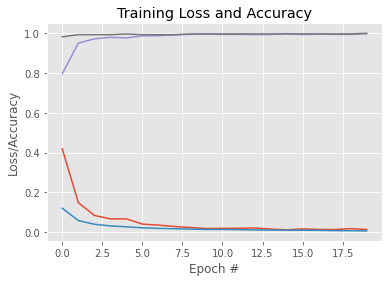

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="middle right")
plt.savefig("plot.png")

- Training loss: 0.0133
- Training accuracy: 0.9972 
- val_loss: 0.0064 
- val_accuracy: 1.0000

## Thanks and now let's go for the testing part